<a href="https://colab.research.google.com/github/SarahGhysels/SarahGhysels_thesis_2024/blob/Data-exploration/ThesisSarahGhysels_Data_exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Data exploration

### Importing functions

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import statistics
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn import metrics

### Reading in data

In [ ]:
#Linking google drive
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
Dataset_multigras= pd.read_csv("/content/drive/MyDrive/Sarah_Ghysels_Thesis/Datamodel/Multigras_data.csv", sep=';')
#DMY
DMY = Dataset_multigras['DMY (kg/ha)']
DMY_int=[]
for i in range(0,len(DMY)):
   try: DMY_int.append(int(DMY[i])) #DMY values are transformed to integers
   except ValueError: DMY_int.append(-544) #there were some DMY values that weren't written down correctly, these were given a negative
   #value to make them easy to delete later (because samples were something went wrong were also annotated with a negative number)
DMY= np.array(DMY_int).reshape(-1,1)
#Score
Score = Dataset_multigras['Score MG']
Score_resh=np.array(Score).reshape(-1,1)
Classes=[]
for i in range(0, len(Score)):
  if Score[i]>=4:
      Classes.append(1)
  elif Score[i]<= 2:
      Classes.append(3)
  else: Classes.append(2)
Class=np.array(Classes).reshape(-1, 1)

### Known information about the data
Images
*   4224 images, from 3 blocks of 44 rows of 32 plants
    - 1 row was deleted for bad stitching -> 4192 images left
*   51x51 pixels
*   PNG format

Breeder score
*   Scores ranging from 0 to 5, 0 being the worst plants and 5 the best
*   Scores are also ordered in classes: Class 1 contains scores of 4 and 5, Class 2 contains score 3 and Class 3 containts scores 0, 1 and 2

Dry matter yield measurements
*   DMY given in kilogram per hectare
*   Missing values or mistakes in dataset represented as -544









### Exploration of the images

The images have all been visually analysed. In the second row of block 3, the orthographic images haven't been correctly stitched together, creating a horizontal translation of half of the plants. This is illustrated below. Therefore this row has been discarded.

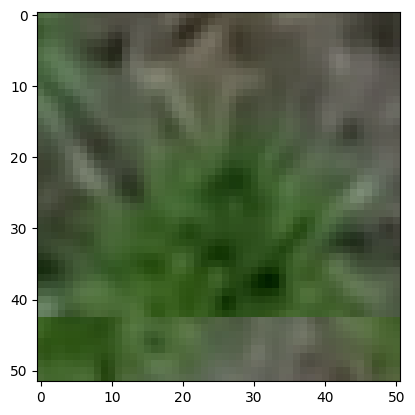

In [ ]:
#Example of an image in block 3 row 2
image = Image.open('/content/drive/MyDrive/Sarah_Ghysels_Thesis/Datamodel/Train/Discard/BLOK3R2P3.png')
plt.imshow(image)

Some images also contain yellow spots. These are assumed to be weeds and are assumed not to interfere too much with the image analysis by the model so they are kept. An example is given below.

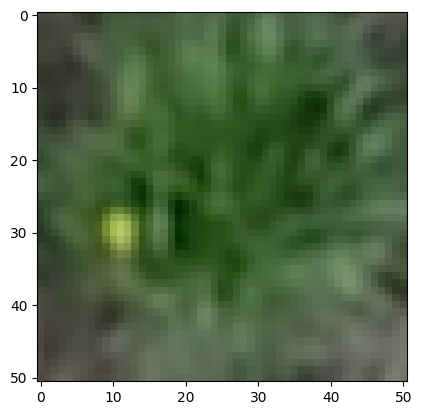

In [ ]:
#Example of an image in block 3 row 2
image = Image.open('/content/drive/MyDrive/Sarah_Ghysels_Thesis/DatamodelNewClips/Train/Discard/BLOK3R28P8.png')
plt.imshow(image)

### Exploration of the breeder scores and classes

Text(0.5, 1.0, "Prevalence distribution of the breeder's scores")

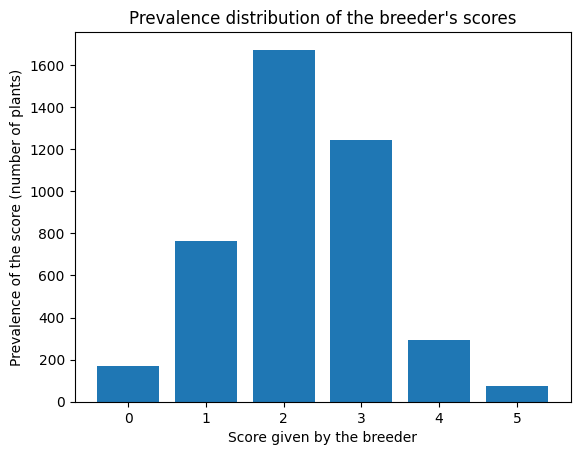

In [ ]:
#Count of scores
CountScores=np.unique(Score, return_counts=True)
plt.bar(CountScores[0], CountScores[1])
plt.xlabel('Score given by the breeder')
plt.ylabel('Prevalence of the score (number of plants)')
plt.title('Prevalence distribution of the breeder\'s scores')

The occurance of the scores is approximately normally distributed. This makes sense.

Text(0.5, 1.0, 'Prevalence distribution of the classes')

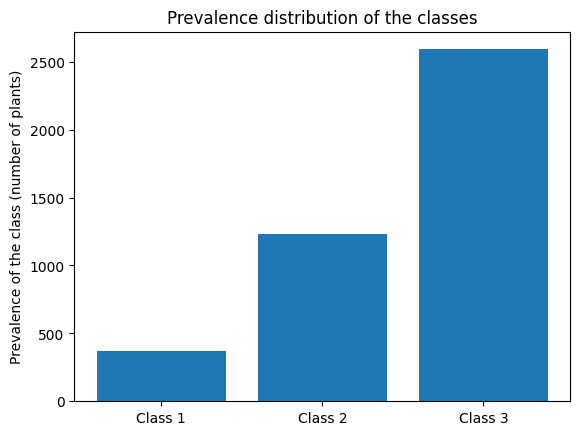

In [ ]:
#Count of classes
Classes = ['Class 1', 'Class 2', 'Class 3']
Number_images = [367, 1233, 2592] #got these numbers from the length of the folders (-1 because Windows explorer counts one too many -> desktop.ini)
plt.bar(Classes, Number_images)
plt.ylabel('Prevalence of the class (number of plants)')
plt.title('Prevalence distribution of the classes')

Class 3 is by far the biggest, which makes sence because it contains scores 0, 1 and 2. Class 1 is by far the smallest. To model this correctly, the class imbalances will have to be taken into account.

### Exploration of the DMY values

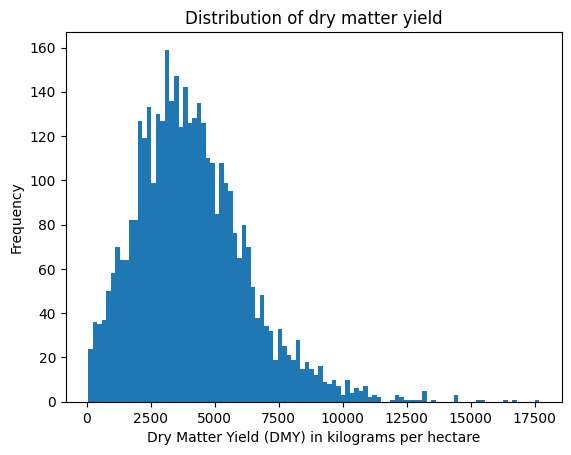

17678


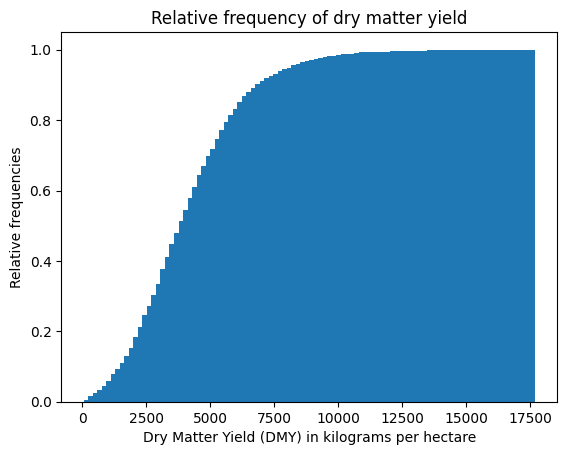

In [ ]:
DMY_intnew=pd.Series(DMY_int)
DMY_hist=DMY_intnew[DMY_intnew>=0] #the negative values (which were mistakes in the procedure) are kept out of this plot
n, bins, patches= plt.hist(DMY_hist, bins=100)
plt.xlabel('Dry Matter Yield (DMY) in kilograms per hectare')
plt.ylabel('Frequency')
plt.title('Distribution of dry matter yield')
plt.show()
print(np.max(DMY_hist))
DMY_mean=statistics.mean(DMY_hist)
DMY_sd = statistics.stdev(DMY_hist)
outlier = DMY_mean+3*DMY_sd

#Probability density histogram
n, bins, patches= plt.hist(DMY_hist, bins=100, density=True, cumulative=True)
plt.xlabel('Dry Matter Yield (DMY) in kilograms per hectare')
plt.ylabel('Relative frequencies')
plt.title('Relative frequency of dry matter yield')
plt.show()

From these plots it's clear that the DMY measurements are a little right skewed. The measurements on the right could be considered as potential outliers. However,  there is no reason to assume these measurements are incorrect, nothing went wrong in their measurement process, and the highest yields are the most interesting for a breeder. Therefore the potential outliers will be kept in the dataset.

### Boxplots of breeder's classes and scores in function of the DMY value

In [ ]:
#Combining data and getting rid of negative values
Data=np.concatenate((Class,DMY, Score_resh), axis=1)
to_delete=[]
for i in range(0,len(DMY)):
  if Data[i,1]<0: to_delete.append(i)

Data_fixed=np.delete(Data,to_delete, axis=0)
X=Data_fixed[:,0].reshape(-1,1) #Class .reshape(-1,1)
y=Data_fixed[:,1].reshape(-1,1) #DMY
X_score=Data_fixed[:,2].reshape(-1,1)

In [ ]:
#Creating dummy variables
enc = OneHotEncoder(sparse_output=False)
X_classdum=enc.fit_transform(X)
X_scoredum=enc.fit_transform(X_score)
#using class and score as a rang variable gave the same results

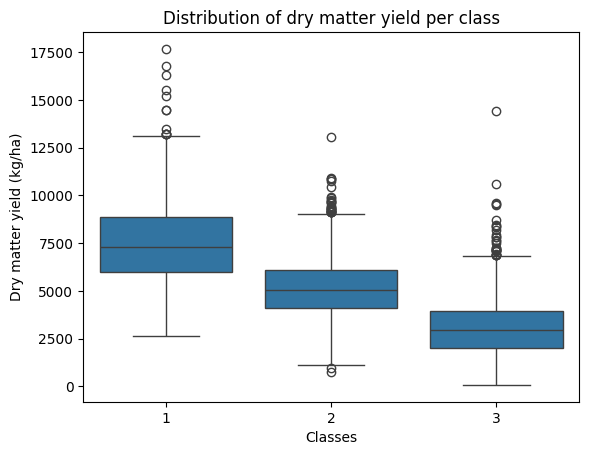

In [ ]:
#Visualization Class and DMY
sns.boxplot(x=Data_fixed[:,0], y=Data_fixed[:,1])
plt.xlabel('Classes')
plt.ylabel('Dry matter yield (kg/ha)')
plt.title('Distribution of dry matter yield per class')
plt.show()

Clearly has a lot of outliers, which are partly incorrectly scored plant and partly just outliers. This will have an impact on the linear regression.

Text(0, 0.5, 'Dry matter yield (kg/ha)')

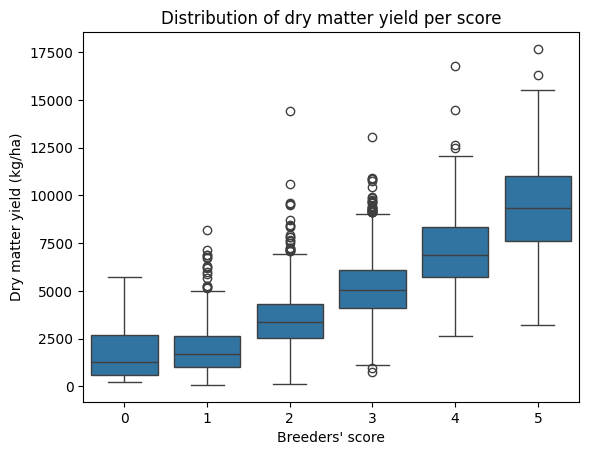

In [ ]:
#Visualization Score and DMY
sns.boxplot(x=Data_fixed[:,2], y=Data_fixed[:,1]).set(title='Distribution of dry matter yield per score')
plt.xlabel('Breeders\' score')
plt.ylabel('Dry matter yield (kg/ha)')

Also quite some wrong scores.

### Linear regression and random forest models of classes and scores as predictors for the DMY values

In [ ]:
X_classtrain, X_classtest, y_classtrain, y_classtest = train_test_split(X_classdum, y, test_size=0.3, random_state=42, stratify=X_classdum)
X_scoretrain, X_scoretest, y_scoretrain, y_scoretest = train_test_split(X_scoredum, y, test_size=0.3, random_state=42, stratify = X_scoredum)

In [ ]:
#Model with class
reg= LinearRegression()
reg.fit(X_classtrain,y_classtrain)
print(reg.coef_)
print(reg.intercept_)
print(reg.score(X_classtrain, y_classtrain))
print(reg.score(X_classtest,y_classtest))
Y_predclass = reg.predict(X_classtest)
print(metrics.mean_squared_error(y_classtest, Y_predclass))

[[7.27414853e+15 7.27414853e+15 7.27414853e+15]]
[-7.27414853e+15]
0.4287185176176098
0.4763764209952833
2713004.066945607


In [ ]:
#Model with Score
reg.fit(X_scoretrain, y_scoretrain)
print(reg.coef_)
print(reg.intercept_)
print(reg.score(X_scoretrain,y_scoretrain))
print(reg.score(X_scoretest,y_scoretest))
Y_predscore = reg.predict(X_scoretest)
print(metrics.mean_squared_error(y_scoretest, Y_predscore))

[[1.13020138e+16 1.13020138e+16 1.13020138e+16 1.13020138e+16
  1.13020138e+16 1.13020138e+16]]
[-1.13020138e+16]
0.5127786686968923
0.551481339350238
2196267.9112970713


In [ ]:
#Random forests
forest= RandomForestRegressor(n_estimators=500, criterion='squared_error', max_depth=7, max_features=0.2)
###
# from sklearn.model_selection import GridSearchCV
# forest  = RandomForestRegressor(n_estimators=500) #max features is the amount of features for each split
# parameter_grid_forest = {
#   "criterion": ['squared_error', 'friedman_mse', 'poisson'], #'absolute_error', 'friedman_mse', 'poisson' (absolute error is very slow)
#   "max_depth": [3,5,7],
#   "ccp_alpha": np.logspace(-4, 4, 10),
#   "max_features": [0.2, 0.5, 0.7]
#   }
# grid_forest = GridSearchCV(forest, parameter_grid_forest)
# grid_forest.fit(X_scoretrain,y_scoretrain.ravel())
# print('The best parameters are: {}'.format(grid_forest.best_params_))
####
#class
forest.fit(X_classtrain, y_classtrain)
print(forest.score(X_classtrain, y_classtrain.ravel()))
print(forest.score(X_classtest, y_classtest))
Y_predclas = forest.predict(X_classtest)
print(metrics.mean_squared_error(y_classtest, Y_predclass))
#score
forest.fit(X_scoretrain, y_scoretrain)
print(forest.score(X_scoretrain, y_scoretrain.ravel()))
print(forest.score(X_scoretest, y_scoretest))
Y_predscore = forest.predict(X_scoretest)
print(metrics.mean_squared_error(y_scoretest, Y_predscore))

<ipython-input-16-b9e88d5ce378>:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  forest.fit(X_classtrain, y_classtrain)


0.42886203620116536
0.47763336805733714
2713004.066945607


<ipython-input-16-b9e88d5ce378>:23: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  forest.fit(X_scoretrain, y_scoretrain)


0.5128062032280609
0.5510138263341742
2198557.1891474226


<ipython-input-17-a2230d56a14e>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  forest.fit(X_classtrain, y_classtrain)


[3064.46351468 5172.91839097 7471.64884829]


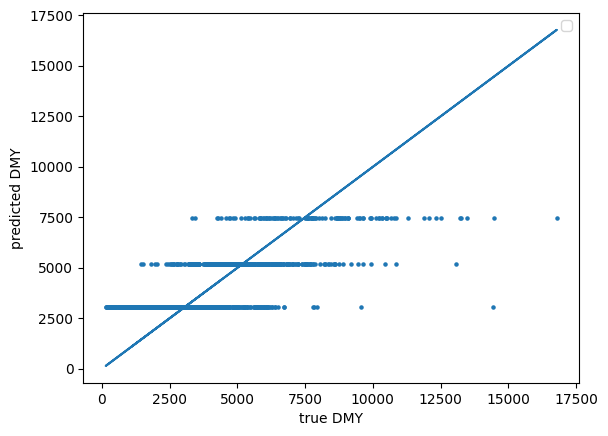

In [ ]:
#Class
forest.fit(X_classtrain, y_classtrain)
Y_pred=forest.predict(X_classtest)
plt.scatter(y_classtest, Y_pred,s =5)
plt.plot(y_classtest, y_classtest)
plt.xlabel('true DMY')
plt.ylabel('predicted DMY')
plt.legend()
print(np.unique(Y_pred))

<ipython-input-18-6bb97886d14d>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  forest.fit(X_scoretrain, y_scoretrain)


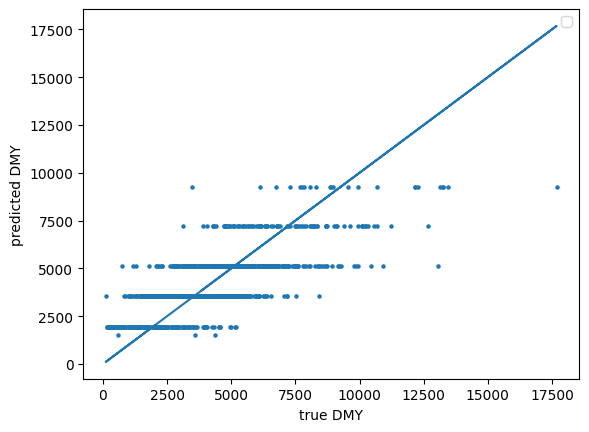

In [ ]:
#Score
forest.fit(X_scoretrain, y_scoretrain)
Y_pred=forest.predict(X_scoretest)
plt.scatter(y_scoretest, Y_pred,s =5)
plt.plot(y_scoretest, y_scoretest)
plt.xlabel('true DMY')
plt.ylabel('predicted DMY')
plt.legend()